# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [15]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import getpass
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

!pip install pymysql
!pip install sqlalchemy pymysql


In [16]:

'''Connection details
#username = 'root'
#password = getpass.getpass('Enter your MySQL password: ')
#host = '127.0.0.1'
#port = '3306'
#database = 'lab-unsupervised-learning'

# Create the connection
#connection_string = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"

# Create the SQLAlchemy
#engine = create_engine(connection_string)

# Load the table into a pandas df
#customers = pd.read_sql('SELECT * FROM wholesale_customers_data', con=engine)

# Verify
customers.head()

# Check if the server is running
!sudo service mysql status

#!!!After approximately an hout of fighting, I found out that Colab cannot connect to a local DB, ahahahah I`ve exported the .sql into a .csv to work with it'''

'Connection details\n#username = \'root\'\n#password = getpass.getpass(\'Enter your MySQL password: \')  \n#host = \'127.0.0.1\'        \n#port = \'3306\'              \n#database = \'lab-unsupervised-learning\'\n\n# Create the connection \n#connection_string = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"\n\n# Create the SQLAlchemy\n#engine = create_engine(connection_string)\n\n# Load the table into a pandas df\n#customers = pd.read_sql(\'SELECT * FROM wholesale_customers_data\', con=engine)\n\n# Verify\ncustomers.head()\n\n# Check if the server is running\n!sudo service mysql status\n\n#After approximately an hout of fighting, I found out that Colab cannot connect to a local DB, ahahahah I`ve exported the .sql into a .csv to work with it'

# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [17]:
customers = pd.read_csv('wholesale_customers_data.csv', delimiter=';')
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [18]:
customers.shape

(1760, 8)

In [19]:
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           1760 non-null   int64
 1   Region            1760 non-null   int64
 2   Fresh             1760 non-null   int64
 3   Milk              1760 non-null   int64
 4   Grocery           1760 non-null   int64
 5   Frozen            1760 non-null   int64
 6   Detergents_Paper  1760 non-null   int64
 7   Delicassen        1760 non-null   int64
dtypes: int64(8)
memory usage: 110.1 KB
None


In [20]:
"""
Channel:  type of sales channel.
Region: where the customer is located.
Fresh: Annual spending on fresh products.
Milk: Annual spending on milk.
Grocery: Annual spending on grocery items.
Frozen: Annual spending on frozen products.
Detergents_Paper: Annual spending on detergents and paper products.
Delicassen: Annual spending on delicatessen products.

The dataset doesn’t contain any missing values.

"""

'\nChannel: Likely represents the type of sales channel.\nRegion: Indicates the region where the customer is located.\nFresh: Annual spending on fresh products.\nMilk: Annual spending on milk.\nGrocery: Annual spending on grocery items.\nFrozen: Annual spending on frozen products.\nDetergents_Paper: Annual spending on detergents and paper products.\nDelicassen: Annual spending on delicatessen products.\n\nThe dataset doesn’t contain any missing values.\n\n'

In [21]:
print(customers['Channel'].unique())
print(customers['Region'].unique())

[2 1]
[3 1 2]


In [22]:
# Encoding categorical data
customers_encoded = pd.get_dummies(customers, columns=['Channel', 'Region'])

In [23]:
# Col collinearity
correlation_matrix = customers.corr()
correlation_matrix

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


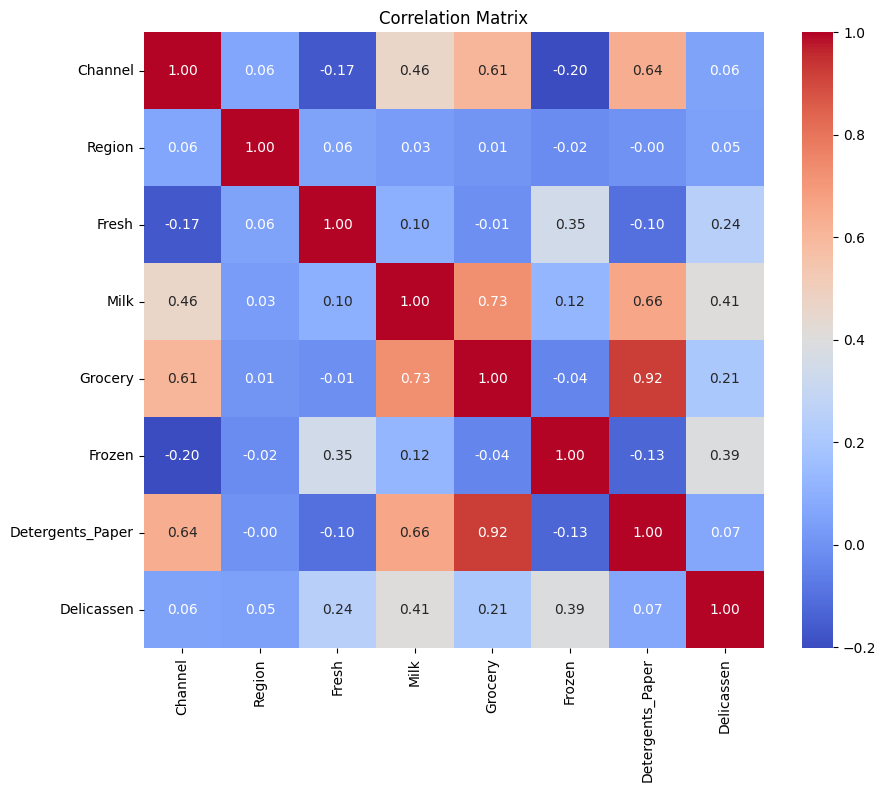

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [25]:
"""
High Correlations:
Milk and Grocery (0.73) and Milk and Detergents_Paper (0.66) have high positive correlations, indicating that customers who
spend a lot on one of these items also tend to spend more on the other.
Grocery and Detergents_Paper have the highest correlation (0.92), suggesting a very strong relationship between spending on
these categories.

"""

'\nHigh Correlations:\nMilk and Grocery (0.73) and Milk and Detergents_Paper (0.66) have high positive correlations, indicating that customers who \nspend a lot on one of these items also tend to spend more on the other.\nGrocery and Detergents_Paper have the highest correlation (0.92), suggesting a very strong relationship between spending on \nthese categories.\n\n'

In [26]:
# Descriptive stats
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.467652,0.773612,12636.539161,7374.080819,9495.055480,4850.531708,4763.786890,2817.700045
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [27]:
"""
The data includes customer segments and product spending categories.
Spending values vary widely with significant outliers.
Skewness is present, indicating some customers spend far more than others, which might impact the model's performance.
"""

'\nThe range values for each feature vary widely, indicating that the scales of different features are not uniform.\nFeatures like Fresh and Grocery have high standard deviations, indicating large variability in these features.\nDetergents_Paper and Delicassen have relatively lower standard deviations, indicating less variability compared to other features.\n'

In [28]:
# Function to detect outliers
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detect outliers for each column
outliers_fresh = detect_outliers(customers, 'Fresh')
outliers_milk = detect_outliers(customers, 'Milk')
outliers_grocery = detect_outliers(customers, 'Grocery')
outliers_frozen = detect_outliers(customers, 'Frozen')
outliers_detergents_paper = detect_outliers(customers, 'Detergents_Paper')
outliers_delicassen = detect_outliers(customers, 'Delicassen')

print("Outliers in Fresh:\n", outliers_fresh)
print("Outliers in Milk:\n", outliers_milk)
print("Outliers in Grocery:\n", outliers_grocery)
print("Outliers in Frozen:\n", outliers_frozen)
print("Outliers in Detergents_Paper:\n", outliers_detergents_paper)
print("Outliers in Delicassen:\n", outliers_delicassen)

Outliers in Fresh:
       Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
29          1       3  43088   2100     2609    1200              1107   
39          1       3  56159    555      902   10002               212   
47          2       3  44466  54259    55571    7782             24171   
52          2       3  40721   3916     5876     532              2587   
87          1       3  43265   5025     8117    6312              1579   
...       ...     ...    ...    ...      ...     ...               ...   
1605        1       3  40254    640     3600    1042               436   
1609        1       3  42786    286      471    1388                32   
1690        2       3  39679   3944     4955    1364               523   
1697        1       3  38793   3154     2648    1034                96   
1756        1       3  39228   1431      764    4510                93   

      Delicassen  
29           823  
39          2916  
47          6465  
52          127

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

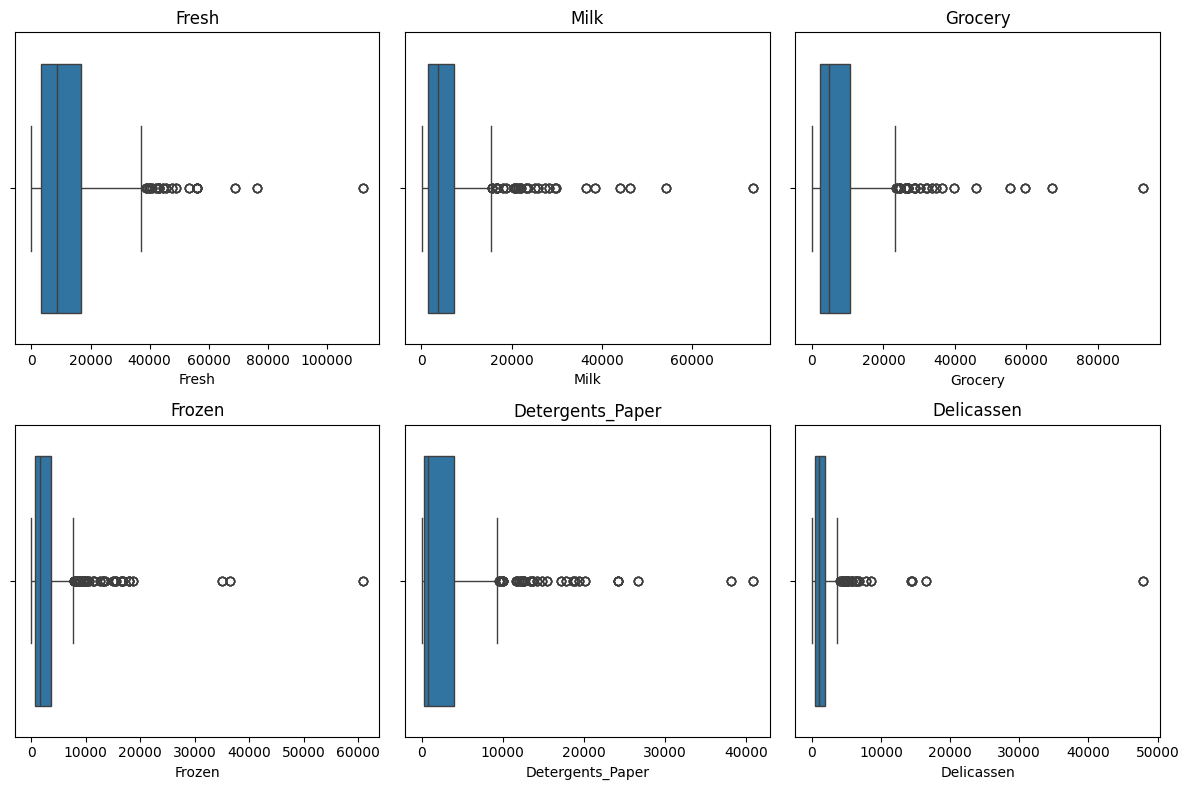

In [29]:
# Visualize outliers
plt.figure(figsize=(12, 8))
for i, column in enumerate(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=customers[column])
    plt.title(column)
plt.tight_layout()
plt.show()

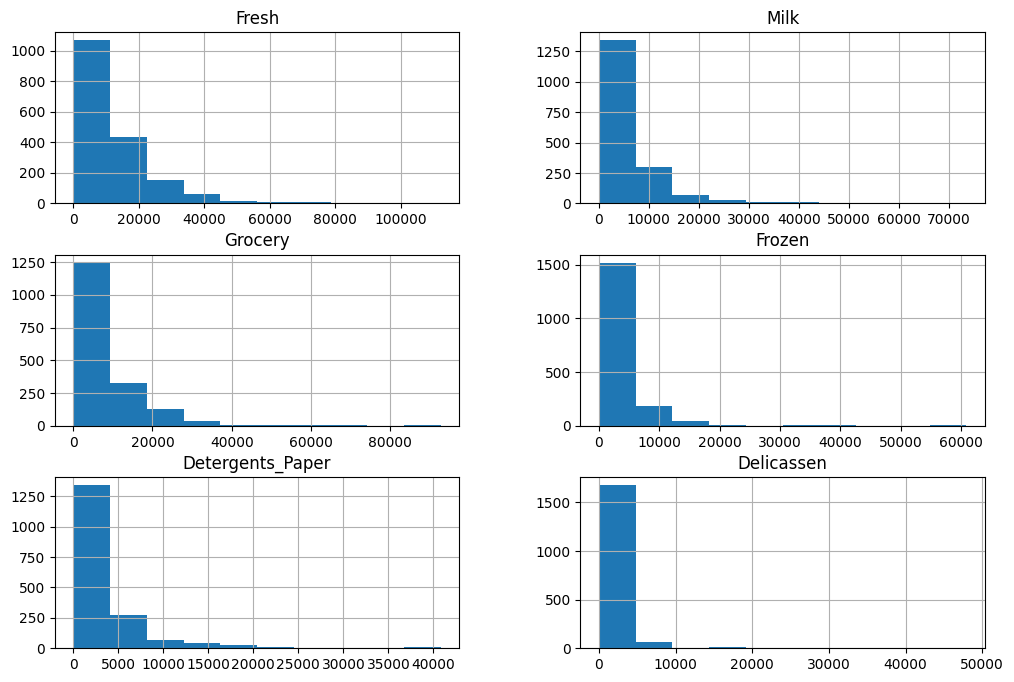

In [30]:
# Data distribution
customers[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].hist(figsize=(12, 8))
plt.show()

In [31]:
skewness = customers.skew()
print(skewness)

Channel              0.759002
Region              -1.280338
Fresh                2.554761
Milk                 4.043369
Grocery              3.578238
Frozen               5.892849
Detergents_Paper     3.622546
Delicassen          11.123016
dtype: float64


In [32]:
"""
Channel (0.759):
Moderately positively skewed.
More customers are in one channel, but the distribution is not extremely biased.

Region (-1.280):
Negatively skewed.
More customers are from regions with lower values (e.g., 1 or 2), while fewer are from higher-numbered regions (3).

Product Categories (Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen):
All product categories show positive skewness:

Fresh (2.55), Milk (4.04), Grocery (3.58):
Moderately to highly skewed. These distributions are right-skewed, meaning many customers have low spending, but there are also some high-value outliers.

Frozen (5.89), Detergents_Paper (3.62):
Highly positively skewed. Most customers spend little on these products, with a few spending a lot.

Delicassen (11.12):
Extremely positively skewed. The distribution is very right-skewed, indicating that the majority of customers have low spending, while a few have very high spending.
"""

'\nFresh:\nStrong positive skewness, indicating a right-skewed distribution\n\nMilk:\nStrong positive skewness, similar to "Fresh". The distribution is right-skewed\n\nGrocery :\nPositive skewness, suggesting a right-skewed distribution\n\nFrozen:\nVery strong positive skewness, indicating a significant right-skew in the distribution\n\nDetergents_Paper:\nPositive skewness, meaning the distribution is right-skewed\n\nDelicassen:\nVery strong positive skewness, suggesting a significant right-skew\n'

In [33]:
# Pareto principle

# Calculate total sales per customer
customers['Total_Sales'] = customers[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].sum(axis=1)

# Sort customers by total sales in descending order
sorted_customers = customers.sort_values(by='Total_Sales', ascending=False)

# Calculate cumulative percentage of total sales
total_sales = sorted_customers['Total_Sales'].sum()
sorted_customers['Cumulative_Sales'] = sorted_customers['Total_Sales'].cumsum()
sorted_customers['Cumulative_Percentage'] = sorted_customers['Cumulative_Sales'] / total_sales * 100

# Determine the percentage of customers that contribute to 80% of sales
top_20_percent_cutoff = 0.2 * len(sorted_customers)
top_20_customers = sorted_customers.head(int(top_20_percent_cutoff))
top_20_sales = top_20_customers['Cumulative_Percentage'].max()

top_20_sales

42.90483942679298

In [53]:
"""
Approximately 42.9% of the total sales come from the top 20% of customers,
 indicating that a significant portion of sales is generated by a smaller segment of customers.
 However, it falls short of the classic 80/20 Pareto distribution—this
 suggests a less pronounced imbalance in customer contributions compared to typical Pareto cases.
"""

'\nApproximately 42.9% of the total sales come from the top 20% of customers,\n indicating that a significant portion of sales is generated by a smaller segment of customers. \n However, it falls short of the classic 80/20 Pareto distribution—this \n suggests a less pronounced imbalance in customer contributions compared to typical Pareto cases.\n'

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [35]:
# Calculate skewness before removing outliers
skewness_before = {
    'Fresh': skew(customers['Fresh']),
    'Milk': skew(customers['Milk']),
    'Grocery': skew(customers['Grocery']),
    'Frozen': skew(customers['Frozen']),
    'Detergents_Paper': skew(customers['Detergents_Paper']),
    'Delicassen': skew(customers['Delicassen'])
}

# Remove outliers
cleaned_customers = customers.copy()
for column in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']:
    outliers = detect_outliers(customers, column)
    cleaned_customers = cleaned_customers[~cleaned_customers.index.isin(outliers.index)]

# Calculate skewness after removing outliers
skewness_after = {
    'Fresh': skew(cleaned_customers['Fresh']),
    'Milk': skew(cleaned_customers['Milk']),
    'Grocery': skew(cleaned_customers['Grocery']),
    'Frozen': skew(cleaned_customers['Frozen']),
    'Detergents_Paper': skew(cleaned_customers['Detergents_Paper']),
    'Delicassen': skew(cleaned_customers['Delicassen'])
}

print("Skewness before removing outliers:", skewness_before)
print("Skewness after removing outliers:", skewness_after)

Skewness before removing outliers: {'Fresh': 2.5525826879071585, 'Milk': 4.039922122788577, 'Grocery': 3.5751872200807875, 'Frozen': 5.887825728957787, 'Detergents_Paper': 3.6194575783115934, 'Delicassen': 11.113533648709097}
Skewness after removing outliers: {'Fresh': 1.0750172824820485, 'Milk': 1.0016437141564474, 'Grocery': 1.198694920292756, 'Frozen': 1.341374552254634, 'Detergents_Paper': 1.237369859117221, 'Delicassen': 1.0298811645136006}


In [36]:
"""
The results show a noticeable improvement in skewness after removing outliers, which suggests that the data distribution has
become more symmetric.

Before Removing Outliers:
Fresh: 2.55 (High positive skew, indicating a long tail on the right)
Milk: 4.04 (Very high positive skew)
Grocery: 3.58 (High positive skew)
Frozen: 5.89 (Extremely high positive skew)
Detergents_Paper: 3.62 (High positive skew)
Delicassen: 11.11 (Extremely high positive skew)

After Removing Outliers:
Fresh: 1.08 (Reduced, but still moderately skewed)
Milk: 1.00 (Reduced to a moderate level)
Grocery: 1.20 (Reduced to a moderate level)
Frozen: 1.34 (Reduced to a moderate level)
Detergents_Paper: 1.24 (Reduced to a moderate level)
Delicassen: 1.03 (Reduced to a moderate level)
"""

'\nThe results show a noticeable improvement in skewness after removing outliers, which suggests that the data distribution has \nbecome more symmetric.\n\nBefore Removing Outliers:\nFresh: 2.55 (High positive skew, indicating a long tail on the right)\nMilk: 4.04 (Very high positive skew)\nGrocery: 3.58 (High positive skew)\nFrozen: 5.89 (Extremely high positive skew)\nDetergents_Paper: 3.62 (High positive skew)\nDelicassen: 11.11 (Extremely high positive skew)\n\nAfter Removing Outliers:\nFresh: 1.08 (Reduced, but still moderately skewed)\nMilk: 1.00 (Reduced to a moderate level)\nGrocery: 1.20 (Reduced to a moderate level)\nFrozen: 1.34 (Reduced to a moderate level)\nDetergents_Paper: 1.24 (Reduced to a moderate level)\nDelicassen: 1.03 (Reduced to a moderate level)\n'

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [37]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the data
customers_scale = scaler.fit_transform(cleaned_customers)

# Convert the scaled data back to a DataFrame with the same column names
customers_scale_df = pd.DataFrame(customers_scale, columns=cleaned_customers.columns)

In [38]:
customers_scale_df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total_Sales
0,1.579474,0.590092,0.383041,1.652898,0.334978,-0.967004,0.305053,0.390465,0.793826
1,1.579474,0.590092,-0.305588,1.698756,0.733878,-0.059255,0.569139,0.922591,0.724912
2,-0.633122,0.590092,0.456174,-0.866283,-0.328862,2.662821,-0.619462,0.937169,0.245530
3,1.579474,0.590092,-0.016491,1.236906,-0.148989,-0.701951,-0.069958,0.527749,0.190872
4,1.579474,0.590092,0.316411,-0.269838,0.218508,-0.811022,0.503864,-0.572949,0.170914
...,...,...,...,...,...,...,...,...,...
1323,-0.633122,0.590092,1.419665,-0.876407,-0.222926,-0.934752,-0.269195,-0.755184,0.379448
1324,-0.633122,0.590092,-0.928323,-0.264181,-0.871064,-0.188850,-0.683883,0.525319,-1.167120
1325,-0.633122,0.590092,0.881474,-0.054547,0.421038,-0.689050,0.175783,-0.216984,0.666099
1326,-0.633122,0.590092,0.091122,-0.632529,-0.724184,-0.483809,-0.764090,1.346590,-0.532152


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

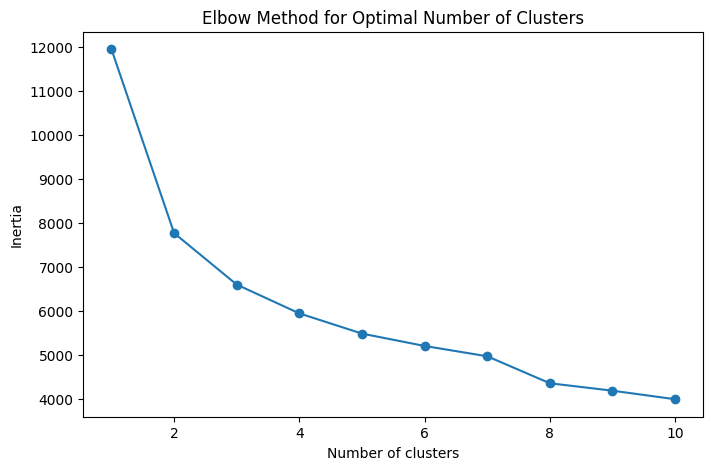

In [39]:
# Range of number of clusters to test
range_n_clusters = list(range(1, 11))

# List to store inertia values
inertia = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customers_scale_df)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [40]:
# Number of clusters
num_clusters = 5

# Initialize the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model on the scaled data
kmeans.fit(customers_scale_df.drop(columns=['Channel', 'Region', 'Total_Sales']))

# Assign the cluster labels to the cleaned_customers df
cleaned_customers['labels'] = kmeans.labels_

# Display the df with labels
cleaned_customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total_Sales,labels
0,2,3,12669,9656,7561,214,2674,1338,34112,1
1,2,3,7057,9810,9568,1762,3293,1776,33266,3
3,1,3,13265,1196,4221,6404,507,1788,27381,0
5,2,3,9413,8259,5126,666,1795,1451,26710,1
6,2,3,12126,3199,6975,480,3140,545,26465,1


Count the values in `labels`.

In [41]:
# Count the number of occurrences of each cluster label
label_counts = cleaned_customers['labels'].value_counts()
label_counts

,count
labels,
2,480
3,236
4,220
1,196
0,196


# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [42]:
# Initialize the DBSCAN model
dbscan = DBSCAN(eps=0.5)

# Fit the model on the scaled data
dbscan.fit(customers_scale_df.drop(columns=['Channel', 'Region', 'Total_Sales']))

# Assign the cluster labels to the cleaned_customers df
cleaned_customers['labels_DBSCAN'] = dbscan.labels_

# Display the df with DBSCAN labels
cleaned_customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total_Sales,labels,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,34112,1,-1
1,2,3,7057,9810,9568,1762,3293,1776,33266,3,-1
3,1,3,13265,1196,4221,6404,507,1788,27381,0,-1
5,2,3,9413,8259,5126,666,1795,1451,26710,1,-1
6,2,3,12126,3199,6975,480,3140,545,26465,1,-1


Count the values in `labels_DBSCAN`.

In [43]:
# Count the values in the 'labels_DBSCAN' column
dbscan_labels_counts = cleaned_customers['labels_DBSCAN'].value_counts()
dbscan_labels_counts

,count
labels_DBSCAN,
-1,944
1,176
4,24
19,16
2,16
3,12
10,12
14,12
12,12


# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

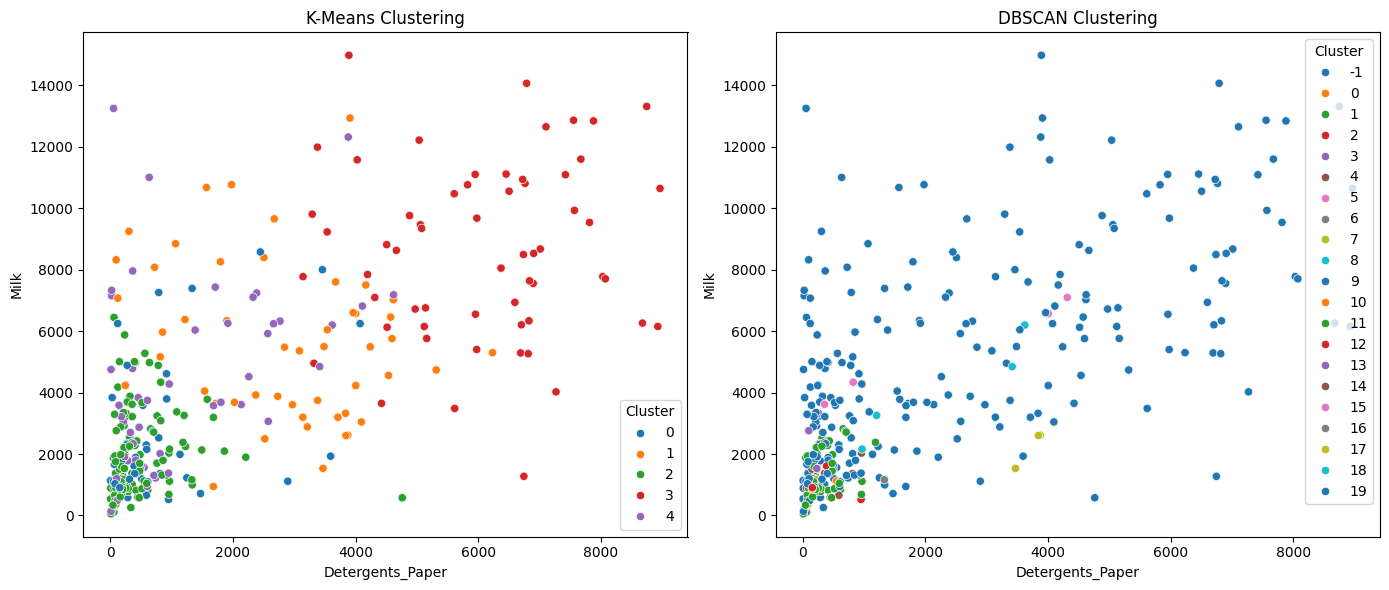

In [44]:
# Set up the plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot using K-Means labels
sns.scatterplot(
    x='Detergents_Paper', y='Milk', hue='labels',
    palette='tab10', data=cleaned_customers, ax=axes[0]
)
axes[0].set_title('K-Means Clustering')
axes[0].legend(title='Cluster')

# Scatter plot using DBSCAN labels
sns.scatterplot(
    x='Detergents_Paper', y='Milk', hue='labels_DBSCAN',
    palette='tab10', data=cleaned_customers, ax=axes[1]
)
axes[1].set_title('DBSCAN Clustering')
axes[1].legend(title='Cluster')

# Show
plt.tight_layout()
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

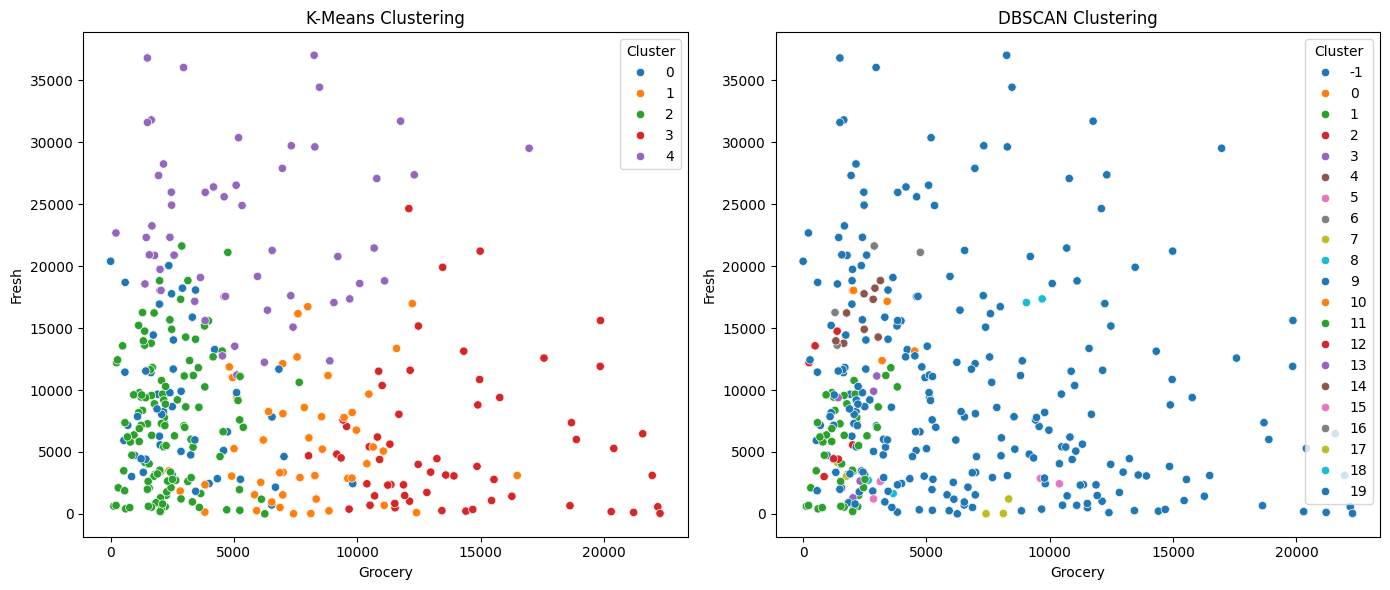

In [45]:
# Set up the plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot using K-Means labels
sns.scatterplot(
    x='Grocery', y='Fresh', hue='labels',
    palette='tab10', data=cleaned_customers, ax=axes[0]
)
axes[0].set_title('K-Means Clustering')
axes[0].legend(title='Cluster')

# Scatter plot using DBSCAN labels
sns.scatterplot(
    x='Grocery', y='Fresh', hue='labels_DBSCAN',
    palette='tab10', data=cleaned_customers, ax=axes[1]
)
axes[1].set_title('DBSCAN Clustering')
axes[1].legend(title='Cluster')

# Show
plt.tight_layout()
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

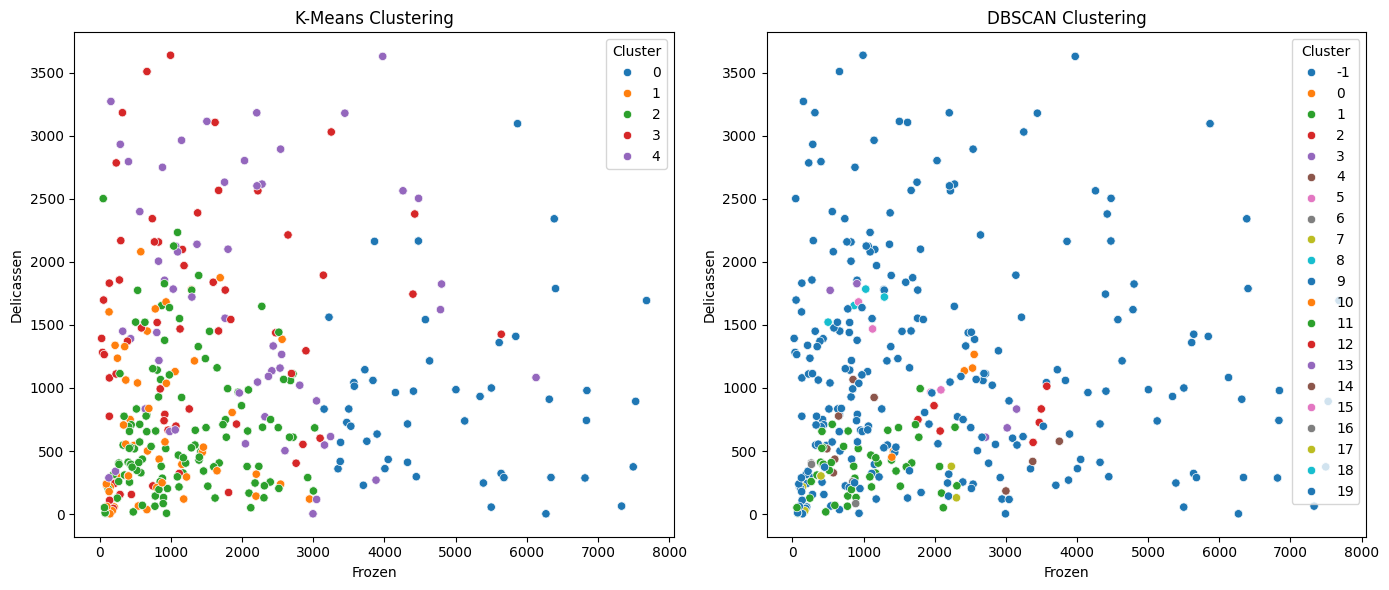

In [46]:
# Set up the plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot using K-Means labels
sns.scatterplot(
    x='Frozen', y='Delicassen', hue='labels',
    palette='tab10', data=cleaned_customers, ax=axes[0]
)
axes[0].set_title('K-Means Clustering')
axes[0].legend(title='Cluster')

# Scatter plot using DBSCAN labels
sns.scatterplot(
    x='Frozen', y='Delicassen', hue='labels_DBSCAN',
    palette='tab10', data=cleaned_customers, ax=axes[1]
)
axes[1].set_title('DBSCAN Clustering')
axes[1].legend(title='Cluster')

# Show
plt.tight_layout()
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [47]:
# Group by K-Means labels and compute mean for each group
kmeans_group_means = cleaned_customers.groupby('labels').mean()

# Group by DBSCAN labels and compute mean for each group
dbscan_group_means = cleaned_customers.groupby('labels_DBSCAN').mean()

# Results
print("Mean values by K-Means clusters:")
print(kmeans_group_means)

print("\nMean values by DBSCAN clusters:")
print(dbscan_group_means)

Mean values by K-Means clusters:
         Channel    Region         Fresh         Milk       Grocery  \
labels                                                                
0       1.040816  2.408163   8757.387755  2478.673469   2992.469388   
1       1.489796  2.612245   5626.673469  5652.408163   7856.306122   
2       1.016667  2.533333   7286.208333  1903.225000   2396.416667   
3       1.915254  2.661017   5645.966102  8649.355932  14119.881356   
4       1.236364  2.472727  22862.909091  4105.418182   5426.745455   

             Frozen  Detergents_Paper   Delicassen   Total_Sales  \
labels                                                             
0       4960.428571        768.346939   892.918367  20850.224490   
1        872.755102       2831.142857   688.734694  23528.020408   
2       1186.191667        454.866667   675.850000  13902.758333   
3       1328.067797       6080.830508  1468.186441  37292.288136   
4       2036.490909       1102.763636  1677.927273  37212.254

Which algorithm appears to perform better?

In [48]:
"""
K-Means provides a more detailed segmentation but might be affected by outliers.
DBSCAN identifies many points as noise and clusters are fewer, which may suggest better handling of outliers and varying cluster shapes.
"""

'\nK-Means provides a more detailed segmentation but might be affected by outliers.\nDBSCAN identifies many points as noise and clusters are fewer, which may suggest better handling of outliers and varying cluster shapes.\n'

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [49]:
# Your code here

In [50]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [51]:
# Your code here

In [52]:
# Your comment here